In [1]:
import os
n_jobs = 64
os.environ["OMP_NUM_THREADS"] = str(n_jobs)
import joblib
import click
import json
import time

import itertools
import collections.abc
import sys
from tqdm.notebook import tqdm
# !{sys.executable} -m pip install qcircuit

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pennylane as qml
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Qiskit
from qiskit import QuantumCircuit
from qiskit.quantum_info import Pauli, SparsePauliOp, Operator
from qiskit.primitives import StatevectorEstimator
from qiskit.circuit import Parameter, ParameterVector
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime.fake_provider import FakeQuebec
from qiskit_ibm_runtime import Batch
from qiskit_ibm_runtime import exceptions
# from qiskit_machine_learning.optimizers import SPSA, Minimizer


from joblib import dump, load
from QiskitRegressor import QiskitRegressor

In [2]:
def mitarai(quantumcircuit,num_wires,paramname='x'):
    # encoding as proposed by Mitarai et al.
    num_features = num_wires
    features = ParameterVector(paramname,num_features*2)
    for i in range(num_wires):
        feature_idx = i % num_features  # Calculate the feature index using modulo
        quantumcircuit.ry(np.arcsin(features[feature_idx * 2]), i)
        quantumcircuit.rz(np.arccos(features[feature_idx * 2 + 1] ** 2), i)


def double_angle(quantumcircuit, num_wires,paramname='x'):
    #  creates a circuit that encodes features into wires via angle encoding with an RY then RZ gate
    #  the features are encoded 1-1 onto the qubits
    #  if more wires are passed then features the remaining wires will be filled from the beginning of the feature list
    num_features = num_wires
    features = ParameterVector(paramname,num_features*2)
    for i in range(num_wires):
        feature_index = i % num_features
        quantumcircuit.ry(features[feature_index], i)
        quantumcircuit.rz(features[feature_index], i)

def entangle_cnot(quantumcircuit,num_wires):
    #  entangles all of the wires in a circular fashion using cnot gates
    for i in range(num_wires):
        
        if i == num_wires - 1:
            quantumcircuit.cx(i, 0)
        else:
            quantumcircuit.cx(i, i+1)


def entangle_cz(quantumcircuit,num_wires):
    #  entangles all of the wires in a circular fashion using cz gates
    for i in range(num_wires):
        
        if i == num_wires - 1:
            quantumcircuit.cz(i, 0)
        else:
            quantumcircuit.cz(i, i+1)


def HardwareEfficient(quantumcircuit,num_wires,paramname='theta'):
    parameters = ParameterVector(paramname,num_wires*3)
    for qubit in range(num_wires):
        quantumcircuit.rx(parameters[qubit * 3], qubit)  
        quantumcircuit.rz(parameters[qubit * 3 + 1], qubit)  
        quantumcircuit.rx(parameters[qubit * 3 + 2], qubit)  
    entangle_cnot(quantumcircuit,num_wires)



In [3]:
# def circuit(nqubits):
#     qc = QuantumCircuit(nqubits)
#     mitarai(qc,nqubits)
#     entangle_cz(qc,nqubits)
#     qc.barrier()
#     mitarai(qc,nqubits,paramname='x1')
#     entangle_cz(qc,nqubits)
#     qc.barrier()
#     HardwareEfficient(qc,nqubits)
#     qc.barrier()
#     return qc


def circuit(nqubits,RUD=1,AL=1):
    qc = QuantumCircuit(nqubits)
    for i in range(RUD):
        double_angle(qc,nqubits,paramname=f'x{i}')
        qc.barrier()
        for j in range(AL):        
            HardwareEfficient(qc,nqubits,paramname=f'theta{i}_{j}')
            qc.barrier()
    return qc

In [4]:

top=os.getcwd()
with open(os.path.join(top,'5_DDCC_train.bin'),'rb') as f:
    ddcc_train = joblib.load(f)

with open(os.path.join(top,'5_DDCC_test.bin'),'rb') as f:
    ddcc_test = joblib.load(f)

with open(os.path.join(top,'5_DDCC_scaler.bin'),'rb') as f:
    ddcc_scaler = joblib.load(f)

X_ddcc_train, y_ddcc_train = ddcc_train['X'],ddcc_train['y']
X_ddcc_test, y_ddcc_test = ddcc_test['X'],ddcc_test['y']

X_ddcc_train = X_ddcc_train.reshape(-1,64,5)[0:4]
X_ddcc_test = X_ddcc_test.reshape(-1,64,5)[0:4]
y_ddcc_train = y_ddcc_train.reshape(-1,64)[0:4]
y_ddcc_test = y_ddcc_test.reshape(-1,64)[0:4]


# X_train, y_train = X_ddcc_train, y_ddcc_train
# X_test, y_test = X_ddcc_test, y_ddcc_test
X_train, y_train = X_ddcc_train, y_ddcc_train
X_test, y_test = X_ddcc_test, y_ddcc_test

# X_train = [X_train[i:i+4] for i in range(0,len(X_train),4)]
# X_test = [X_test[i:i+4] for i in range(0,len(X_test),4)]
scaler = ddcc_scaler

# print(len(X_train),X_train[0].shape,X_train[-1].shape)
print(y_train.shape, y_test.shape)

(4, 64) (4, 64)


/home/ubuntu/miniconda3/envs/qml/lib/python3.11/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [5]:
num_qubits = 5
RUD = 1
AL = 5

In [6]:
optimization_level = 2
shots = 3072
# shots = 1024.0 * 1
resilience_level = 1

In [7]:
optimization_level = int(optimization_level)
shots = int(shots)
# shots = 1024.0 * 1
resilience_level = int(resilience_level)

In [8]:
# 
qc = circuit(num_qubits,RUD,AL)

observables_labels = ''.join(['I']*(num_qubits-1))+"Z"

In [9]:
model = QiskitRegressor(qc,
                        num_qubits,
                        AL,
                        RUD,
                        'real', #'fake',
                        observables_labels,
                        verbose=True,
                        instance='pinq-quebec-hub/univ-toronto/default',
                        iterations=275,
                        n_jobs=n_jobs,
                        parameterpath='./partial_state_model.bin')
model.fit(X_train,y_train)



./partial_state_model.bin
Parameters loaded
[ 0.16603458  4.48856562 -1.84410156  2.24766078  2.1438566  -2.58751108
  4.83217924  2.0391672   1.75350903  1.11892647  2.31151024  2.23569473
  0.75963214 -0.86282502  2.20140131  4.20374675 -0.9759864  -0.5648943
 -1.23750415  1.07027178  2.72538015  3.58902199 -1.29311055 -0.45798537
 -3.05732747 -2.47884188  3.25878251  1.77055297  0.47753309 -3.07606347
  1.46250224  0.86842325 -2.48710525  1.81949489  0.76520842 -0.73576734
  0.88402353 -1.84989881  0.66077101  2.7694038  -0.59167491  0.18259674
  2.42843055  0.31370041  2.3951637   3.17496029  2.71776925 -2.95516683
 -0.87333719 -0.41528285  1.26375461  2.73112443 -0.37988213 -2.46094223
  2.50921147 -3.07784244  1.74081982 -0.75307909 -1.82621155  2.86050922
 -2.39677886 -1.51371371 -2.72146328  2.95553723 -2.60705492  1.68495907
  1.59338194  2.56262334  2.14823996  2.70240411  1.15328219  1.4132453
 -2.07226232 -2.7651304   1.27120093]


[SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII'],
              coeffs=[1.+0.j])]
<IBMBackend('ibm_quebec')>


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.5687 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 1808.5142 s
Iters. done: 1 Current cost: 0.11718695812746302 Accuracy: -0.29547283199797914 Time: 1829.1634711362422


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.3480 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 2653.9038 s
Iters. done: 2 Current cost: 0.13625586070398982 Accuracy: -0.5062748326526703 Time: 2673.3853475488722


Mappings: 0it [00:00, ?it/s]

Submitted to device in 25.2381 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 1680.7186 s
Iters. done: 3 Current cost: 0.12207711685719835 Accuracy: -0.3495323270114028 Time: 1706.0536192283034


Mappings: 0it [00:00, ?it/s]

/home/ubuntu/miniconda3/envs/qml/lib/python3.11/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:874: UserWarning: The backend ibm_quebec currently has a status of internal.
  warnings.warn(


Submitted to device in 18.1653 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 1984.8458 s
Iters. done: 4 Current cost: 0.11248397191782745 Accuracy: -0.24348248289089525 Time: 2003.0930067449808


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.0672 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 2370.7060 s
Iters. done: 5 Current cost: 0.11334347252149386 Accuracy: -0.2529840494382971 Time: 2389.8742469474673


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.0938 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 2990.3631 s
Iters. done: 6 Current cost: 0.13199904942015095 Accuracy: -0.4592168369740255 Time: 3009.543962005526


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.5816 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 359.4427 s
Iters. done: 7 Current cost: 0.12171708864958777 Accuracy: -0.3455523042412483 Time: 380.1222587674856


Mappings: 0it [00:00, ?it/s]

Submitted to device in 22.1120 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 2336.4101 s
Iters. done: 8 Current cost: 0.10518808199140595 Accuracy: -0.16282822463592495 Time: 2358.610448613763


Mappings: 0it [00:00, ?it/s]

Submitted to device in 18.6784 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 2477.2270 s
Iters. done: 9 Current cost: 0.11459456538713342 Accuracy: -0.2668145715684105 Time: 2495.991337593645


Mappings: 0it [00:00, ?it/s]

Submitted to device in 21.2182 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 1389.6950 s
Iters. done: 10 Current cost: 0.11862503370890472 Accuracy: -0.3113704017948764 Time: 1411.0120435357094


Mappings: 0it [00:00, ?it/s]

/home/ubuntu/miniconda3/envs/qml/lib/python3.11/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:874: UserWarning: The backend ibm_quebec currently has a status of internal.
  warnings.warn(


Submitted to device in 19.4581 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 1740.6196 s
Iters. done: 11 Current cost: 0.08547893981055807 Accuracy: 0.05505146645992409 Time: 1760.1847502030432


Mappings: 0it [00:00, ?it/s]

Submitted to device in 18.6944 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 2229.6967 s
Iters. done: 12 Current cost: 0.10411975520082685 Accuracy: -0.15101813625232285 Time: 2248.491358138621


Mappings: 0it [00:00, ?it/s]

Submitted to device in 17.7457 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 2184.0213 s
Iters. done: 13 Current cost: 0.10788968390540499 Accuracy: -0.19269376546387895 Time: 2201.8672777079046


Mappings: 0it [00:00, ?it/s]

Submitted to device in 23.0757 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 2786.2583 s
Iters. done: 14 Current cost: 0.09635393744150725 Accuracy: -0.06516894205698098 Time: 2809.429600663483


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.7057 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 144.3654 s
Iters. done: 15 Current cost: 0.08112700904053566 Accuracy: 0.10316098452735178 Time: 165.16813660040498


Mappings: 0it [00:00, ?it/s]

Submitted to device in 17.2813 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 1772.6867 s
Iters. done: 16 Current cost: 0.09518639885202919 Accuracy: -0.052262091779897046 Time: 1790.0572889633477


Mappings: 0it [00:00, ?it/s]

Submitted to device in 18.3600 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 2037.1835 s
Iters. done: 17 Current cost: 0.08770249133003469 Accuracy: 0.030470654481711934 Time: 2055.6453708708286


Mappings: 0it [00:00, ?it/s]

Submitted to device in 21.7253 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 1418.8912 s
Iters. done: 18 Current cost: 0.08415456435803861 Accuracy: 0.06969210945910365 Time: 1440.7109438441694


Mappings: 0it [00:00, ?it/s]

/home/ubuntu/miniconda3/envs/qml/lib/python3.11/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:874: UserWarning: The backend ibm_quebec currently has a status of internal.
  warnings.warn(


Submitted to device in 20.9599 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 1314.4252 s
Iters. done: 19 Current cost: 0.08754606775123278 Accuracy: 0.032199878448779695 Time: 1335.4824681021273


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.3949 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 2181.0806 s
Iters. done: 20 Current cost: 0.09605043294876056 Accuracy: -0.06181377497162144 Time: 2201.5676805116236


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.9000 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 2303.1925 s
Iters. done: 21 Current cost: 0.09191749807642499 Accuracy: -0.016125202377185177 Time: 2323.196557752788


Mappings: 0it [00:00, ?it/s]

Submitted to device in 21.6564 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 2599.3170 s
Iters. done: 22 Current cost: 0.08727074166604032 Accuracy: 0.035243540209495716 Time: 2621.0721823759377


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.3391 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 2386.4614 s
Iters. done: 23 Current cost: 0.07807564855112704 Accuracy: 0.1368930198820142 Time: 2405.91761950776


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.4575 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 2310.2712 s
Iters. done: 24 Current cost: 0.08584451280349512 Accuracy: 0.05101014745967314 Time: 2329.8216467760503


Mappings: 0it [00:00, ?it/s]

Submitted to device in 21.7471 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 1202.8543 s
Iters. done: 25 Current cost: 0.10339223646605053 Accuracy: -0.14297559661538517 Time: 1224.700702842325


Mappings: 0it [00:00, ?it/s]

/home/ubuntu/miniconda3/envs/qml/lib/python3.11/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:874: UserWarning: The backend ibm_quebec currently has a status of internal.
  warnings.warn(


Submitted to device in 18.3770 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 2269.4037 s
Iters. done: 26 Current cost: 0.08193067639112936 Accuracy: 0.09427664078045206 Time: 2287.875168237835


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.5448 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 2179.3079 s
Iters. done: 27 Current cost: 0.0897308730293318 Accuracy: 0.008047396583822253 Time: 2198.9550712555647


Mappings: 0it [00:00, ?it/s]

Submitted to device in 17.9700 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 1156.6423 s
Iters. done: 28 Current cost: 0.10837810130051861 Accuracy: -0.19809309894053362 Time: 1174.714995842427


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.7049 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 1217.0087 s
Iters. done: 29 Current cost: 0.07532150795356604 Accuracy: 0.16733936285955076 Time: 1237.8163320943713


Mappings: 0it [00:00, ?it/s]

Submitted to device in 22.0111 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 2666.7942 s
Iters. done: 30 Current cost: 0.07953035405080834 Accuracy: 0.12081161045294286 Time: 2688.895121935755


Mappings: 0it [00:00, ?it/s]

Submitted to device in 22.1539 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 6539.8172 s
Iters. done: 31 Current cost: 0.07853997524226819 Accuracy: 0.13176000317813652 Time: 6562.073777031153


Mappings: 0it [00:00, ?it/s]

/home/ubuntu/miniconda3/envs/qml/lib/python3.11/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:874: UserWarning: The backend ibm_quebec currently has a status of internal.
  warnings.warn(


Submitted to device in 18.7616 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 203.3957 s
Iters. done: 32 Current cost: 0.07929039719691403 Accuracy: 0.12346427411141647 Time: 222.2725261375308


Mappings: 0it [00:00, ?it/s]

/home/ubuntu/miniconda3/envs/qml/lib/python3.11/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:874: UserWarning: The backend ibm_quebec currently has a status of internal.
  warnings.warn(


Submitted to device in 21.1685 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 115.3153 s
Iters. done: 33 Current cost: 0.08601237774509124 Accuracy: 0.04915444205731789 Time: 136.57958984375


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.3157 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 118.2067 s
Iters. done: 34 Current cost: 0.07869204522352125 Accuracy: 0.13007890715496395 Time: 137.60248491168022


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.1977 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 115.8013 s
Iters. done: 35 Current cost: 0.08910309998568516 Accuracy: 0.01498727228074348 Time: 135.09436556696892


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.3317 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 188.6386 s
Iters. done: 36 Current cost: 0.0962400452377569 Accuracy: -0.06390989191955465 Time: 208.0619511306286


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.6934 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 122.2437 s
Iters. done: 37 Current cost: 0.08972388551610647 Accuracy: 0.00812464181393402 Time: 143.0339954905212


Mappings: 0it [00:00, ?it/s]

Submitted to device in 21.9120 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 122.4524 s
Iters. done: 38 Current cost: 0.09191812770163463 Accuracy: -0.016132162728118793 Time: 144.46143978834152


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.1562 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 118.1132 s
Iters. done: 39 Current cost: 0.09128995887887896 Accuracy: -0.009187911791056491 Time: 137.3596431352198


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.9208 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 128.8032 s
Iters. done: 40 Current cost: 0.08345462051392995 Accuracy: 0.07742981550127881 Time: 149.82301822677255


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.0795 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 127.5282 s
Iters. done: 41 Current cost: 0.08709412219656143 Accuracy: 0.03719602475187056 Time: 147.69328692927957


Mappings: 0it [00:00, ?it/s]

Submitted to device in 17.7658 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 127.8910 s
Iters. done: 42 Current cost: 0.09290634681151982 Accuracy: -0.0270566805189556 Time: 145.73763320967555


Mappings: 0it [00:00, ?it/s]

Submitted to device in 21.4893 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 117.5118 s
Iters. done: 43 Current cost: 0.08296406176471768 Accuracy: 0.08285282111775849 Time: 139.53895243257284


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.8152 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 116.9962 s
Iters. done: 44 Current cost: 0.078991259728051 Accuracy: 0.12677116482807105 Time: 136.9106343574822


Mappings: 0it [00:00, ?it/s]

Submitted to device in 17.8494 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 119.2317 s
Iters. done: 45 Current cost: 0.0791330568846692 Accuracy: 0.12520363233991105 Time: 137.16758550330997


Mappings: 0it [00:00, ?it/s]

Submitted to device in 18.6404 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 117.6857 s
Iters. done: 46 Current cost: 0.07923476215805336 Accuracy: 0.12407930570283943 Time: 136.41835667565465


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.4929 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 116.8668 s
Iters. done: 47 Current cost: 0.08818092918826036 Accuracy: 0.025181642316582598 Time: 136.45106330513954


Mappings: 0it [00:00, ?it/s]

Submitted to device in 18.9009 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 116.8628 s
Iters. done: 48 Current cost: 0.07481378429982061 Accuracy: 0.1729521222493332 Time: 135.8619891665876


Mappings: 0it [00:00, ?it/s]

Submitted to device in 28.6713 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 117.1431 s
Iters. done: 49 Current cost: 0.08023812836142212 Accuracy: 0.1129873405406806 Time: 145.89807046577334


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.1537 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 154.9962 s
Iters. done: 50 Current cost: 0.08942386204022566 Accuracy: 0.01144132711898671 Time: 174.23796949535608


Mappings: 0it [00:00, ?it/s]

Submitted to device in 18.8959 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 381.1285 s
Iters. done: 51 Current cost: 0.07870464867191632 Accuracy: 0.12993957915083953 Time: 400.11867567896843


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.8768 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 309.9368 s
Iters. done: 52 Current cost: 0.0879041033195017 Accuracy: 0.028241883813601487 Time: 330.9033558219671


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.8079 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 146.0451 s
Iters. done: 53 Current cost: 0.08183555540859506 Accuracy: 0.09532817971102225 Time: 166.949514310807


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.6155 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 316.1264 s
Iters. done: 54 Current cost: 0.0808545153217188 Accuracy: 0.10617333517846572 Time: 335.8325839266181


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.1573 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 115.9989 s
Iters. done: 55 Current cost: 0.07794668125813989 Accuracy: 0.1383187214016275 Time: 136.25752091780305


Mappings: 0it [00:00, ?it/s]

Submitted to device in 18.9082 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 1056.1701 s
Iters. done: 56 Current cost: 0.07900380769814597 Accuracy: 0.12663245012282998 Time: 1075.1694542728364


Mappings: 0it [00:00, ?it/s]

Submitted to device in 18.8011 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 117.6901 s
Iters. done: 57 Current cost: 0.09613434725646877 Accuracy: -0.06274142688433404 Time: 136.58193949982524


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.6255 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 117.8928 s
Iters. done: 58 Current cost: 0.08737438762273907 Accuracy: 0.03409775979847407 Time: 138.60531495511532


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.4838 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 116.5590 s
Iters. done: 59 Current cost: 0.08536489716118555 Accuracy: 0.056312179736485835 Time: 136.14072077721357


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.0545 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 118.2281 s
Iters. done: 60 Current cost: 0.09083598767217771 Accuracy: -0.00416937240588755 Time: 137.37778812274337


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.6280 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 170.1787 s
Iters. done: 61 Current cost: 0.08400371037275692 Accuracy: 0.07135976294763002 Time: 189.8979940265417


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.7335 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 145.5278 s
Iters. done: 62 Current cost: 0.07829860194446107 Accuracy: 0.13442832527366155 Time: 165.35507209971547


Mappings: 0it [00:00, ?it/s]

Submitted to device in 36.2838 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 107.5200 s
Iters. done: 63 Current cost: 0.07427934194467095 Accuracy: 0.1788602502733777 Time: 143.89701322466135


Mappings: 0it [00:00, ?it/s]

Submitted to device in 24.1410 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 114.8849 s
Iters. done: 64 Current cost: 0.07816376220503263 Accuracy: 0.13591894523593795 Time: 139.11531383544207


Mappings: 0it [00:00, ?it/s]

Submitted to device in 18.6819 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 118.2468 s
Iters. done: 65 Current cost: 0.08720730582470261 Accuracy: 0.03594480774251374 Time: 137.01497288793325


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.0775 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 117.5836 s
Iters. done: 66 Current cost: 0.09253628383145848 Accuracy: -0.02296572582179346 Time: 138.08120281621814


Mappings: 0it [00:00, ?it/s]

Submitted to device in 18.8466 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 120.0823 s
Iters. done: 67 Current cost: 0.09470060899929528 Accuracy: -0.04689180513423996 Time: 139.02226712182164


Mappings: 0it [00:00, ?it/s]

Submitted to device in 18.7217 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 119.7668 s
Iters. done: 68 Current cost: 0.07762705760176963 Accuracy: 0.14185208185323295 Time: 138.57326286286116


Mappings: 0it [00:00, ?it/s]

Submitted to device in 17.6170 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 119.1234 s
Iters. done: 69 Current cost: 0.08516110878997848 Accuracy: 0.058565009766331944 Time: 137.28198562189937


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.9972 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 115.9349 s
Iters. done: 70 Current cost: 0.10016072272521488 Accuracy: -0.10725201163311016 Time: 136.020371183753


Mappings: 0it [00:00, ?it/s]

Submitted to device in 21.1050 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 117.5032 s
Iters. done: 71 Current cost: 0.08016913367971079 Accuracy: 0.11375005967886453 Time: 138.69749937579036


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.7759 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 119.3285 s
Iters. done: 72 Current cost: 0.09687704010577683 Accuracy: -0.07095171260359678 Time: 139.1916828341782


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.7515 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 140.6857 s
Iters. done: 73 Current cost: 0.09326230132763305 Accuracy: -0.03099166963736999 Time: 160.5256769619882


Mappings: 0it [00:00, ?it/s]

Submitted to device in 22.1058 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 115.5954 s
Iters. done: 74 Current cost: 0.103119449902784 Accuracy: -0.13996000864132485 Time: 137.78479712828994


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.3888 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 117.5351 s
Iters. done: 75 Current cost: 0.0798935893209432 Accuracy: 0.1167961343999564 Time: 137.02250527963042


Mappings: 0it [00:00, ?it/s]

Submitted to device in 22.3095 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 117.0407 s
Iters. done: 76 Current cost: 0.08765909800322036 Accuracy: 0.030950356974858262 Time: 139.44008661806583


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.5722 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 116.0771 s
Iters. done: 77 Current cost: 0.07495191729006839 Accuracy: 0.17142509621394442 Time: 135.73308689147234


Mappings: 0it [00:00, ?it/s]

Submitted to device in 17.6850 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 122.8286 s
Iters. done: 78 Current cost: 0.07585358717306528 Accuracy: 0.16145735871552114 Time: 140.601613227278


Mappings: 0it [00:00, ?it/s]

Submitted to device in 18.1981 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 119.4983 s
Iters. done: 79 Current cost: 0.07828105284324466 Accuracy: 0.1346223262462538 Time: 137.7881622724235


Mappings: 0it [00:00, ?it/s]

Submitted to device in 21.8396 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 115.8060 s
Iters. done: 80 Current cost: 0.07966385428409753 Accuracy: 0.11933579839966446 Time: 137.74224073067307


Mappings: 0it [00:00, ?it/s]

Submitted to device in 25.3435 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 119.7050 s
Iters. done: 81 Current cost: 0.08311914866709609 Accuracy: 0.08113837377788113 Time: 145.14021417498589


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.8149 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 117.2983 s
Iters. done: 82 Current cost: 0.0734167247718723 Accuracy: 0.18839626972154921 Time: 137.19791002944112


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.0035 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 116.7525 s
Iters. done: 83 Current cost: 0.07049802251113998 Accuracy: 0.22066180117563083 Time: 136.8447758667171


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.7857 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 118.7443 s
Iters. done: 84 Current cost: 0.0746993838373646 Accuracy: 0.17421679106101573 Time: 139.617343403399


Mappings: 0it [00:00, ?it/s]

Submitted to device in 18.6844 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 118.1149 s
Iters. done: 85 Current cost: 0.07776446669524464 Accuracy: 0.14033305831758713 Time: 136.89389802142978


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.9351 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 115.0632 s
Iters. done: 86 Current cost: 0.07427707792417468 Accuracy: 0.178885278459883 Time: 136.09667614102364


Mappings: 0it [00:00, ?it/s]

Submitted to device in 22.3650 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 116.9708 s
Iters. done: 87 Current cost: 0.08473912995516697 Accuracy: 0.06322988139463959 Time: 139.43096275255084


Mappings: 0it [00:00, ?it/s]

Submitted to device in 18.3175 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 130.1450 s
Iters. done: 88 Current cost: 0.07043392361688582 Accuracy: 0.22137039859461216 Time: 148.54645509645343


Mappings: 0it [00:00, ?it/s]

Submitted to device in 45.9055 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 130.4806 s
Iters. done: 89 Current cost: 0.07869689225633437 Accuracy: 0.13002532440629 Time: 176.47007723152637


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.7717 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 129.2767 s
Iters. done: 90 Current cost: 0.06964377837236019 Accuracy: 0.23010525880407318 Time: 150.13615169003606


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.5219 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 130.5100 s
Iters. done: 91 Current cost: 0.07891027367306008 Accuracy: 0.12766644563139484 Time: 150.1168574616313


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.6157 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 133.6716 s
Iters. done: 92 Current cost: 0.07145461286088209 Accuracy: 0.2100869315037478 Time: 153.37323150411248


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.3358 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 135.8317 s
Iters. done: 93 Current cost: 0.06698473989069245 Accuracy: 0.25950027141708876 Time: 156.25804606825113


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.0352 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 138.6801 s
Iters. done: 94 Current cost: 0.06838598072026197 Accuracy: 0.2440099006898344 Time: 157.80231238901615


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.2851 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 137.4195 s
Iters. done: 95 Current cost: 0.07411660880654587 Accuracy: 0.18065922485788322 Time: 156.78958118334413


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.1579 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 140.0745 s
Iters. done: 96 Current cost: 0.06826022100425322 Accuracy: 0.2454001432394527 Time: 159.31311591342092


Mappings: 0it [00:00, ?it/s]

Submitted to device in 21.2420 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 120.7655 s
Iters. done: 97 Current cost: 0.07014832689033186 Accuracy: 0.22452759975479397 Time: 142.09693261235952


Mappings: 0it [00:00, ?it/s]

Submitted to device in 18.0425 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 118.8606 s
Iters. done: 98 Current cost: 0.07074542291554126 Accuracy: 0.21792685090771313 Time: 136.98696112260222


Mappings: 0it [00:00, ?it/s]

Submitted to device in 21.3560 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 116.7731 s
Iters. done: 99 Current cost: 0.08540836801163 Accuracy: 0.05583162023878652 Time: 138.21419915929437


Mappings: 0it [00:00, ?it/s]

Submitted to device in 17.5932 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 122.0488 s
Iters. done: 100 Current cost: 0.06782533335652591 Accuracy: 0.25020771860111923 Time: 139.74240946397185


Mappings: 0it [00:00, ?it/s]

Submitted to device in 23.4430 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 115.5886 s
Iters. done: 101 Current cost: 0.08409275291433467 Accuracy: 0.07037541967812933 Time: 139.12028152868152


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.4472 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 118.2821 s
Iters. done: 102 Current cost: 0.06731086403317282 Accuracy: 0.25589504969964794 Time: 138.82868817448616


Mappings: 0it [00:00, ?it/s]

Submitted to device in 21.1438 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 117.2598 s
Iters. done: 103 Current cost: 0.0733853299412135 Accuracy: 0.18874333180792424 Time: 138.4902684725821


Mappings: 0it [00:00, ?it/s]

Submitted to device in 17.7678 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 119.2724 s
Iters. done: 104 Current cost: 0.07190689083211593 Accuracy: 0.20508711041779282 Time: 137.13893104717135


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.0420 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 640.5189 s
Iters. done: 105 Current cost: 0.07804068563014019 Accuracy: 0.13727952632427964 Time: 660.6520393081009


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.9619 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 592.6322 s
Iters. done: 106 Current cost: 0.06755156552129754 Accuracy: 0.25323415429396723 Time: 612.677901674062


Mappings: 0it [00:00, ?it/s]

Submitted to device in 23.4831 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 524.4670 s
Iters. done: 107 Current cost: 0.08270347934503723 Accuracy: 0.08573349530357655 Time: 548.0456106215715


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.5121 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 1560.5178 s
Iters. done: 108 Current cost: 0.06706857887196878 Accuracy: 0.25857345221944616 Time: 1580.1177745237947


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.7154 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 3675.7436 s
Iters. done: 109 Current cost: 0.07251864865507052 Accuracy: 0.19832427902372352 Time: 3696.546631015837


Mappings: 0it [00:00, ?it/s]

Submitted to device in 23.0208 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 631.3828 s
Iters. done: 110 Current cost: 0.07296857625309933 Accuracy: 0.19335044073210705 Time: 654.5128732211888


Mappings: 0it [00:00, ?it/s]

Submitted to device in 21.2748 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 646.5531 s
Iters. done: 111 Current cost: 0.08331165674744939 Accuracy: 0.07901024457286732 Time: 667.9220319837332


Mappings: 0it [00:00, ?it/s]

Submitted to device in 21.3341 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 526.7782 s
Iters. done: 112 Current cost: 0.07014780102648947 Accuracy: 0.2245334130494816 Time: 548.2001393847167


Mappings: 0it [00:00, ?it/s]

Submitted to device in 22.2065 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 673.3570 s
Iters. done: 113 Current cost: 0.07719761787767952 Accuracy: 0.14659943176681578 Time: 695.6617338433862


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.4411 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 532.5480 s
Iters. done: 114 Current cost: 0.07065566431199423 Accuracy: 0.21891911006514242 Time: 552.0690279304981


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.8851 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 579.8909 s
Iters. done: 115 Current cost: 0.07598667834733916 Accuracy: 0.15998606870846266 Time: 600.8633523359895


Mappings: 0it [00:00, ?it/s]

Submitted to device in 21.9708 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 714.2521 s
Iters. done: 116 Current cost: 0.07199547413215363 Accuracy: 0.20410784394990877 Time: 736.3178824745119


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.1267 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 774.7408 s
Iters. done: 117 Current cost: 0.08172276722076413 Accuracy: 0.0965750252255746 Time: 794.9727321267128


Mappings: 0it [00:00, ?it/s]

Submitted to device in 21.2321 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 550.2292 s
Iters. done: 118 Current cost: 0.07824691001009759 Accuracy: 0.13499976682032644 Time: 571.5463175363839


Mappings: 0it [00:00, ?it/s]

Submitted to device in 17.2901 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 519.0073 s
Iters. done: 119 Current cost: 0.0710010562582233 Accuracy: 0.21510088754379342 Time: 536.3870433457196


Mappings: 0it [00:00, ?it/s]

Submitted to device in 21.2235 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 753.3841 s
Iters. done: 120 Current cost: 0.0771298758364394 Accuracy: 0.1473483032744728 Time: 774.6939858645201


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.8073 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 562.7226 s
Iters. done: 121 Current cost: 0.08532409957352766 Accuracy: 0.05676318697540028 Time: 582.6184064000845


Mappings: 0it [00:00, ?it/s]

Submitted to device in 18.4106 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 524.4523 s
Iters. done: 122 Current cost: 0.07393789334134279 Accuracy: 0.18263488011447448 Time: 542.9594776444137


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.3474 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 592.5633 s
Iters. done: 123 Current cost: 0.0740615511636184 Accuracy: 0.18126787348010276 Time: 613.0031886138022


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.0026 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 713.0200 s
Iters. done: 124 Current cost: 0.07945247782655089 Accuracy: 0.12167251284682845 Time: 732.1198527961969


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.9208 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 177.0159 s
Iters. done: 125 Current cost: 0.07188062833678516 Accuracy: 0.2053774358067707 Time: 197.0272418372333


Mappings: 0it [00:00, ?it/s]

Submitted to device in 17.2337 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 128.4963 s
Iters. done: 126 Current cost: 0.0728290694244969 Accuracy: 0.1948926542106416 Time: 145.82293808087707


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.7130 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 119.5342 s
Iters. done: 127 Current cost: 0.08927007521527187 Accuracy: 0.013141402424552417 Time: 140.3427594602108


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.6951 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 121.0487 s
Iters. done: 128 Current cost: 0.06895895880524355 Accuracy: 0.23767576970559556 Time: 140.82170549035072


Mappings: 0it [00:00, ?it/s]

Submitted to device in 18.6274 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 122.3274 s
Iters. done: 129 Current cost: 0.08190426347806634 Accuracy: 0.09456862900024898 Time: 141.0438047759235


Mappings: 0it [00:00, ?it/s]

Submitted to device in 18.4457 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 117.1824 s
Iters. done: 130 Current cost: 0.07101724172452287 Accuracy: 0.21492196121786633 Time: 135.72838538140059


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.5752 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 116.9594 s
Iters. done: 131 Current cost: 0.07948194765947947 Accuracy: 0.12134673113414873 Time: 136.62381168082356


Mappings: 0it [00:00, ?it/s]

Submitted to device in 18.2196 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 118.2099 s
Iters. done: 132 Current cost: 0.07317552612931336 Accuracy: 0.1910626610465126 Time: 136.50837176665664


Mappings: 0it [00:00, ?it/s]

Submitted to device in 23.2335 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 113.6118 s
Iters. done: 133 Current cost: 0.07283291783773144 Accuracy: 0.1948501109543671 Time: 136.93971516937017


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.4998 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 117.8104 s
Iters. done: 134 Current cost: 0.06989289848287353 Accuracy: 0.2273512976105132 Time: 138.39087169617414


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.0241 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 117.0945 s
Iters. done: 135 Current cost: 0.07246875240865498 Accuracy: 0.19887586968434712 Time: 136.20473462343216


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.1274 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 117.7837 s
Iters. done: 136 Current cost: 0.07188102702323794 Accuracy: 0.2053730284266636 Time: 138.39241937547922


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.7791 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 116.9254 s
Iters. done: 137 Current cost: 0.0801808002354592 Accuracy: 0.11362108879117727 Time: 137.79393251612782


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.1106 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 115.6854 s
Iters. done: 138 Current cost: 0.06939159863534042 Accuracy: 0.23289304341176098 Time: 135.88845533132553


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.5959 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 121.5015 s
Iters. done: 139 Current cost: 0.09087964388840353 Accuracy: -0.004651981076443379 Time: 141.19128151237965


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.1930 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 116.6090 s
Iters. done: 140 Current cost: 0.0730709066027806 Accuracy: 0.1922192040312043 Time: 135.8946587331593


Mappings: 0it [00:00, ?it/s]

Submitted to device in 22.0124 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 114.2865 s
Iters. done: 141 Current cost: 0.07517909722700256 Accuracy: 0.1689136782116688 Time: 136.3844047859311


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.2582 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 117.0899 s
Iters. done: 142 Current cost: 0.07920457184853891 Accuracy: 0.12441305210594211 Time: 137.43368485569954


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.4856 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 115.7566 s
Iters. done: 143 Current cost: 0.08495968224575708 Accuracy: 0.06079173038312824 Time: 136.33152592554688


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.6565 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 119.6093 s
Iters. done: 144 Current cost: 0.07369469111034395 Accuracy: 0.18532342061398643 Time: 139.36172211915255


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.7958 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 119.2644 s
Iters. done: 145 Current cost: 0.07286809061512625 Accuracy: 0.19446128460142664 Time: 139.15066355839372


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.1595 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 116.8460 s
Iters. done: 146 Current cost: 0.07927381529030761 Accuracy: 0.12364758298686296 Time: 137.09577052295208


Mappings: 0it [00:00, ?it/s]

Submitted to device in 21.0986 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 116.5381 s
Iters. done: 147 Current cost: 0.07421368341847925 Accuracy: 0.17958608903760143 Time: 137.73422461375594


Mappings: 0it [00:00, ?it/s]

Submitted to device in 17.7331 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 118.3960 s
Iters. done: 148 Current cost: 0.07581711711869982 Accuracy: 0.16186052614444757 Time: 136.21310967579484


Mappings: 0it [00:00, ?it/s]

Submitted to device in 17.7513 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 124.8505 s
Iters. done: 149 Current cost: 0.07074411938828108 Accuracy: 0.2179412610791035 Time: 142.68947810679674


Mappings: 0it [00:00, ?it/s]

Submitted to device in 21.7613 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 138.8625 s
Iters. done: 150 Current cost: 0.07533882236340624 Accuracy: 0.16714795634206392 Time: 161.10854530707002


Mappings: 0it [00:00, ?it/s]

Submitted to device in 21.7057 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 114.7115 s
Iters. done: 151 Current cost: 0.07297920181068773 Accuracy: 0.19323297782155313 Time: 136.50674675032496


Mappings: 0it [00:00, ?it/s]

Submitted to device in 21.9600 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 114.2748 s
Iters. done: 152 Current cost: 0.07209240356313314 Accuracy: 0.2030363130691567 Time: 136.323332734406


Mappings: 0it [00:00, ?it/s]

Submitted to device in 18.1845 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 118.7240 s
Iters. done: 153 Current cost: 0.06922017165288125 Accuracy: 0.2347881262946676 Time: 136.99628759920597


Mappings: 0it [00:00, ?it/s]

Submitted to device in 23.5387 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 114.0065 s
Iters. done: 154 Current cost: 0.07319487015341715 Accuracy: 0.19084881764543438 Time: 138.04863351210952


Mappings: 0it [00:00, ?it/s]

Submitted to device in 18.7443 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 118.4632 s
Iters. done: 155 Current cost: 0.07194252357990519 Accuracy: 0.20469319920593076 Time: 137.30102802440524


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.4898 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 119.3644 s
Iters. done: 156 Current cost: 0.07439834201123949 Accuracy: 0.1775447339760965 Time: 140.33417370542884


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.9112 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 119.1223 s
Iters. done: 157 Current cost: 0.07148139809275039 Accuracy: 0.20979082739166377 Time: 139.1279884763062


Mappings: 0it [00:00, ?it/s]

Submitted to device in 23.1393 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 123.2813 s
Iters. done: 158 Current cost: 0.07224637459160949 Accuracy: 0.20133420143921799 Time: 146.50456144288182


Mappings: 0it [00:00, ?it/s]

Submitted to device in 21.4296 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 113.8960 s
Iters. done: 159 Current cost: 0.07265916812964662 Accuracy: 0.19677087099446167 Time: 135.41295451670885


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.6980 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 117.9484 s
Iters. done: 160 Current cost: 0.0790736654613292 Accuracy: 0.12586018983248615 Time: 138.74583914875984


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.0993 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 118.0237 s
Iters. done: 161 Current cost: 0.07385134482317435 Accuracy: 0.18359165257216514 Time: 137.2185595035553


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.7264 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 116.4772 s
Iters. done: 162 Current cost: 0.07329151682378063 Accuracy: 0.18978041261334233 Time: 136.3051832355559


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.3693 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 121.8140 s
Iters. done: 163 Current cost: 0.06890148187229102 Accuracy: 0.23831116298055022 Time: 141.2709130719304


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.3221 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 116.2729 s
Iters. done: 164 Current cost: 0.07137813115637207 Accuracy: 0.2109324178268065 Time: 135.6848027035594


Mappings: 0it [00:00, ?it/s]

Submitted to device in 22.8031 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 115.1797 s
Iters. done: 165 Current cost: 0.06632542159653715 Accuracy: 0.26678887205461377 Time: 138.57665308192372


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.3739 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 117.2617 s
Iters. done: 166 Current cost: 0.0683022955901193 Accuracy: 0.2449350191012547 Time: 137.72464679554105


Mappings: 0it [00:00, ?it/s]

Submitted to device in 22.1102 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 114.8146 s
Iters. done: 167 Current cost: 0.06817265116187884 Accuracy: 0.24636820618358124 Time: 137.01350344717503


Mappings: 0it [00:00, ?it/s]

Submitted to device in 23.7899 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 112.8459 s
Iters. done: 168 Current cost: 0.07288169894330374 Accuracy: 0.19431084789989828 Time: 136.72938556224108


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.7012 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 116.6003 s
Iters. done: 169 Current cost: 0.07331515603504501 Accuracy: 0.1895190869807616 Time: 137.3876110240817


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.8004 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 116.7509 s
Iters. done: 170 Current cost: 0.07048978807437714 Accuracy: 0.2207528308369816 Time: 137.03982021287084


Mappings: 0it [00:00, ?it/s]

Submitted to device in 81.6861 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 89.0967 s
Iters. done: 171 Current cost: 0.0760398374727327 Accuracy: 0.15939840772791913 Time: 170.8744046613574


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.7701 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 116.6221 s
Iters. done: 172 Current cost: 0.0767406218310642 Accuracy: 0.15165141000893967 Time: 137.47965398430824


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.5993 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 115.4163 s
Iters. done: 173 Current cost: 0.07035595524515374 Accuracy: 0.22223231965603396 Time: 136.10466163232923


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.3857 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 117.9998 s
Iters. done: 174 Current cost: 0.07107083119871309 Accuracy: 0.21432954283783656 Time: 137.4728565737605


Mappings: 0it [00:00, ?it/s]

Submitted to device in 26.9888 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 241.2698 s
Iters. done: 175 Current cost: 0.07405736454785951 Accuracy: 0.18131415548161833 Time: 268.3500051610172


Mappings: 0it [00:00, ?it/s]

Submitted to device in 22.0660 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 116.8565 s
Iters. done: 176 Current cost: 0.0689961284116007 Accuracy: 0.23726486890245868 Time: 139.01960955932736


Mappings: 0it [00:00, ?it/s]

Submitted to device in 18.6298 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 119.3633 s
Iters. done: 177 Current cost: 0.07488115852593782 Accuracy: 0.1722073168468684 Time: 138.09330989420414


Mappings: 0it [00:00, ?it/s]

Submitted to device in 18.5870 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 120.7013 s
Iters. done: 178 Current cost: 0.07372489164574975 Accuracy: 0.1849895611661847 Time: 139.38044206425548


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.9209 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 117.7669 s
Iters. done: 179 Current cost: 0.07391387571995835 Accuracy: 0.18290038897732008 Time: 139.2347900904715


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.3377 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 154.7362 s
Iters. done: 180 Current cost: 0.07681841371535887 Accuracy: 0.15079143997247824 Time: 174.15737422555685


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.8253 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 1006.1790 s
Iters. done: 181 Current cost: 0.07019424551489822 Accuracy: 0.22401998071971552 Time: 1026.598946068436


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.9009 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 116.6039 s
Iters. done: 182 Current cost: 0.0683434928875849 Accuracy: 0.24447959316929757 Time: 137.59859025105834


Mappings: 0it [00:00, ?it/s]

Submitted to device in 18.9723 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 119.4050 s
Iters. done: 183 Current cost: 0.06676123065805904 Accuracy: 0.26197111069139056 Time: 138.47281577810645


Mappings: 0it [00:00, ?it/s]

Submitted to device in 22.2449 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 1937.5538 s
Iters. done: 184 Current cost: 0.07886281628961253 Accuracy: 0.12819107526524154 Time: 1959.8857552334666


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.0398 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 119.8597 s
Iters. done: 185 Current cost: 0.07168319780352526 Accuracy: 0.20755998151093402 Time: 139.99921599030495


Mappings: 0it [00:00, ?it/s]

Submitted to device in 17.0792 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 1118.0024 s
Iters. done: 186 Current cost: 0.06479492894575173 Accuracy: 0.2837080896906625 Time: 1135.1728461496532


Mappings: 0it [00:00, ?it/s]

Submitted to device in 21.1905 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 160.4109 s
Iters. done: 187 Current cost: 0.067343571764967 Accuracy: 0.2555334738160112 Time: 181.68820359185338


Mappings: 0it [00:00, ?it/s]

Submitted to device in 18.7196 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 117.4665 s
Iters. done: 188 Current cost: 0.0676716586504043 Accuracy: 0.2519065544607315 Time: 136.27251613140106


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.7361 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 116.5697 s
Iters. done: 189 Current cost: 0.0689008835939709 Accuracy: 0.23831777679937505 Time: 136.39511777833104


Mappings: 0it [00:00, ?it/s]

Submitted to device in 17.6197 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 118.7136 s
Iters. done: 190 Current cost: 0.0711182005011051 Accuracy: 0.21380588691826918 Time: 136.4262480698526


Mappings: 0it [00:00, ?it/s]

Submitted to device in 16.7713 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 118.6699 s
Iters. done: 191 Current cost: 0.07340573250809801 Accuracy: 0.1885177864782711 Time: 135.5337594524026


Mappings: 0it [00:00, ?it/s]

Submitted to device in 17.9864 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 118.5759 s
Iters. done: 192 Current cost: 0.0729241034839346 Accuracy: 0.19384207619340088 Time: 136.65428883954883


Mappings: 0it [00:00, ?it/s]

Submitted to device in 23.1361 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 120.8911 s
Iters. done: 193 Current cost: 0.07163766260356214 Accuracy: 0.20806336188187657 Time: 144.12298233807087


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.1599 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 117.1496 s
Iters. done: 194 Current cost: 0.07376481967287724 Accuracy: 0.18454816670381902 Time: 137.40813713148236


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.1067 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 116.7612 s
Iters. done: 195 Current cost: 0.07222202185144305 Accuracy: 0.2016034149572956 Time: 135.95982059836388


Mappings: 0it [00:00, ?it/s]

Submitted to device in 18.5390 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 154.0263 s
Iters. done: 196 Current cost: 0.07289740143628766 Accuracy: 0.1941372607244961 Time: 172.65554001554847


Mappings: 0it [00:00, ?it/s]

Submitted to device in 21.7825 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 161.7818 s
Iters. done: 197 Current cost: 0.07339244643003398 Accuracy: 0.1886646607845146 Time: 183.66612185165286


Mappings: 0it [00:00, ?it/s]

Submitted to device in 21.1060 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 129.1377 s
Iters. done: 198 Current cost: 0.07388022870162897 Accuracy: 0.18327234844123963 Time: 150.33388098329306


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.1789 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 122.3112 s
Iters. done: 199 Current cost: 0.07384349226147859 Accuracy: 0.18367846069911886 Time: 141.57680999860168


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.5027 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 119.8224 s
Iters. done: 200 Current cost: 0.07376524876547312 Accuracy: 0.1845434231913219 Time: 139.40610055997968


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.1860 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 119.4417 s
Iters. done: 201 Current cost: 0.0720564810517027 Accuracy: 0.20343342754638927 Time: 138.72585540637374


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.5379 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 119.6719 s
Iters. done: 202 Current cost: 0.07022680220345238 Accuracy: 0.22366007458173165 Time: 139.2979810461402


Mappings: 0it [00:00, ?it/s]

Submitted to device in 21.2691 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 118.8852 s
Iters. done: 203 Current cost: 0.06863509449935623 Accuracy: 0.2412560094885462 Time: 140.25362180918455


Mappings: 0it [00:00, ?it/s]

Submitted to device in 24.4142 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 137.6857 s
Iters. done: 204 Current cost: 0.06935049954246061 Accuracy: 0.23334738371631636 Time: 162.186913844198


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.9444 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 119.6137 s
Iters. done: 205 Current cost: 0.0698086515208729 Accuracy: 0.22828262693413526 Time: 140.64686743170023


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.1171 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 119.5513 s
Iters. done: 206 Current cost: 0.06840964540395728 Accuracy: 0.24374829346583138 Time: 140.2474109493196


Mappings: 0it [00:00, ?it/s]

Submitted to device in 18.7869 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 117.6171 s
Iters. done: 207 Current cost: 0.07077139326690216 Accuracy: 0.21763975509805067 Time: 136.49784590303898


Mappings: 0it [00:00, ?it/s]

Submitted to device in 22.3034 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 225.2777 s
Iters. done: 208 Current cost: 0.07039113212464636 Accuracy: 0.221843447955417 Time: 247.67058505490422


Mappings: 0it [00:00, ?it/s]

Submitted to device in 18.1336 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 173.4771 s
Iters. done: 209 Current cost: 0.07282391894864386 Accuracy: 0.19494959144705504 Time: 192.20180121064186


Mappings: 0it [00:00, ?it/s]

Submitted to device in 21.0975 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 115.5343 s
Iters. done: 210 Current cost: 0.07080571181959422 Accuracy: 0.21726037198787818 Time: 136.7281491085887


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.5673 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 117.2537 s
Iters. done: 211 Current cost: 0.07111065244432191 Accuracy: 0.21388932881874378 Time: 137.9125117622316


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.9787 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 126.8904 s
Iters. done: 212 Current cost: 0.0717479604389505 Accuracy: 0.20684404659750522 Time: 146.96261981502175


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.7026 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 131.9839 s
Iters. done: 213 Current cost: 0.07329125581602458 Accuracy: 0.18978329798951643 Time: 151.79073878005147


Mappings: 0it [00:00, ?it/s]

Submitted to device in 26.6000 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 125.1871 s
Iters. done: 214 Current cost: 0.07282678335814731 Accuracy: 0.1949179261086016 Time: 151.8729893900454


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.1999 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 130.3094 s
Iters. done: 215 Current cost: 0.06891710809618605 Accuracy: 0.23813841894105814 Time: 149.60561148822308


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.5835 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 132.1041 s
Iters. done: 216 Current cost: 0.07236634325126327 Accuracy: 0.2000079775849931 Time: 151.78822924941778


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.8499 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 133.0032 s
Iters. done: 217 Current cost: 0.06921672535873813 Accuracy: 0.234826224223864 Time: 153.4308085143566


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.5414 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 129.9078 s
Iters. done: 218 Current cost: 0.07425406512515643 Accuracy: 0.1791396792600466 Time: 149.52731507271528


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.9977 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 131.3446 s
Iters. done: 219 Current cost: 0.07092761155315888 Accuracy: 0.21591280058928408 Time: 151.434606410563


Mappings: 0it [00:00, ?it/s]

Submitted to device in 23.7386 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 130.3774 s
Iters. done: 220 Current cost: 0.071314840468845 Accuracy: 0.21163208072035666 Time: 154.20516150817275


Mappings: 0it [00:00, ?it/s]

Submitted to device in 18.6362 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 133.1593 s
Iters. done: 221 Current cost: 0.07578819656978045 Accuracy: 0.1621802356582892 Time: 151.8904649578035


Mappings: 0it [00:00, ?it/s]

Submitted to device in 21.1812 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 129.0091 s
Iters. done: 222 Current cost: 0.06962128313498668 Accuracy: 0.2303539380882903 Time: 150.2952677682042


Mappings: 0it [00:00, ?it/s]

Submitted to device in 21.1384 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 127.7649 s
Iters. done: 223 Current cost: 0.0688419511572976 Accuracy: 0.23896926030789534 Time: 148.99927048012614


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.3439 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 207.2650 s
Iters. done: 224 Current cost: 0.07215602994918084 Accuracy: 0.20233293911150718 Time: 227.6974597275257


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.0387 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 126.8914 s
Iters. done: 225 Current cost: 0.0773601362368655 Accuracy: 0.14480283151034934 Time: 146.01683377102017


Mappings: 0it [00:00, ?it/s]

Submitted to device in 30.5125 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 126.8793 s
Iters. done: 226 Current cost: 0.0742730271271016 Accuracy: 0.17893005901942616 Time: 157.47694370523095


Mappings: 0it [00:00, ?it/s]

Submitted to device in 23.5991 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 130.2857 s
Iters. done: 227 Current cost: 0.07100809952397719 Accuracy: 0.21502302598327072 Time: 153.97100794315338


Mappings: 0it [00:00, ?it/s]

Submitted to device in 22.2656 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 135.3617 s
Iters. done: 228 Current cost: 0.0712778405473473 Accuracy: 0.21204110569934942 Time: 157.72318622469902


Mappings: 0it [00:00, ?it/s]

Submitted to device in 21.0032 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 133.9712 s
Iters. done: 229 Current cost: 0.06828415901132284 Accuracy: 0.24513551449316207 Time: 155.5653957426548


Mappings: 0it [00:00, ?it/s]

Submitted to device in 22.8399 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 162.7302 s
Iters. done: 230 Current cost: 0.06693768574841352 Accuracy: 0.2600204433195714 Time: 185.66182853654027


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.5644 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 130.5895 s
Iters. done: 231 Current cost: 0.07182837375102454 Accuracy: 0.20595509732544048 Time: 151.2349161542952


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.5656 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 132.0004 s
Iters. done: 232 Current cost: 0.06941138689461446 Accuracy: 0.23267428910077215 Time: 153.14243074133992


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.7637 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 148.1138 s
Iters. done: 233 Current cost: 0.06967805802230498 Accuracy: 0.22972630575414776 Time: 167.96572871133685


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.6648 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 161.5348 s
Iters. done: 234 Current cost: 0.06885266598346818 Accuracy: 0.23885081055524915 Time: 181.28935181349516


Mappings: 0it [00:00, ?it/s]

Submitted to device in 21.2576 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 124.4662 s
Iters. done: 235 Current cost: 0.06939118768610171 Accuracy: 0.23289758635393298 Time: 145.81025232374668


Mappings: 0it [00:00, ?it/s]

Submitted to device in 23.1604 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 127.1106 s
Iters. done: 236 Current cost: 0.06977522128757521 Accuracy: 0.2286521898931585 Time: 150.35588443279266


Mappings: 0it [00:00, ?it/s]

Submitted to device in 22.7576 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 129.3494 s
Iters. done: 237 Current cost: 0.06677265449493297 Accuracy: 0.26184482300081624 Time: 152.1963274180889


Mappings: 0it [00:00, ?it/s]

Submitted to device in 21.6221 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 130.7590 s
Iters. done: 238 Current cost: 0.0707427894984574 Accuracy: 0.2179559626821117 Time: 152.4775917492807


Mappings: 0it [00:00, ?it/s]

Submitted to device in 22.3955 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 132.2828 s
Iters. done: 239 Current cost: 0.07008146459556448 Accuracy: 0.22526674588282947 Time: 154.76702469587326


Mappings: 0it [00:00, ?it/s]

Submitted to device in 49.1777 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 132.1376 s
Iters. done: 240 Current cost: 0.07209269363106738 Accuracy: 0.20303310643990158 Time: 182.00830183550715


Mappings: 0it [00:00, ?it/s]

Submitted to device in 21.4507 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 128.5488 s
Iters. done: 241 Current cost: 0.07499085989325309 Accuracy: 0.1709945953694888 Time: 150.56871074810624


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.1725 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 123.3932 s
Iters. done: 242 Current cost: 0.07001708581336885 Accuracy: 0.225978437393764 Time: 143.65896333381534


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.5816 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 140.8737 s
Iters. done: 243 Current cost: 0.07186465901236248 Accuracy: 0.20555397273771858 Time: 160.54255234450102


Mappings: 0it [00:00, ?it/s]

Submitted to device in 23.0177 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 119.2805 s
Iters. done: 244 Current cost: 0.07238680709486489 Accuracy: 0.19978175485639116 Time: 142.39708135277033


Mappings: 0it [00:00, ?it/s]

Submitted to device in 23.6927 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 116.9486 s
Iters. done: 245 Current cost: 0.06866276717358906 Accuracy: 0.24095009492066088 Time: 140.7306744158268


Mappings: 0it [00:00, ?it/s]

Submitted to device in 22.8701 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 120.7506 s
Iters. done: 246 Current cost: 0.06624295727527987 Accuracy: 0.2677004947258137 Time: 144.208010006696


Mappings: 0it [00:00, ?it/s]

Submitted to device in 22.3893 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 118.6517 s
Iters. done: 247 Current cost: 0.06593706709961375 Accuracy: 0.2710820349456694 Time: 141.1269917525351


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.2280 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 121.4737 s
Iters. done: 248 Current cost: 0.06694032550415582 Accuracy: 0.2599912614728719 Time: 141.7859479226172


Mappings: 0it [00:00, ?it/s]

Submitted to device in 21.4967 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 119.8930 s
Iters. done: 249 Current cost: 0.06681972507506037 Accuracy: 0.26132446938198517 Time: 141.47521723806858


Mappings: 0it [00:00, ?it/s]

Submitted to device in 23.9829 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 118.2345 s
Iters. done: 250 Current cost: 0.06575460828082012 Accuracy: 0.2730990720501608 Time: 142.2995888516307


Mappings: 0it [00:00, ?it/s]

Submitted to device in 23.4498 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 122.2591 s
Iters. done: 251 Current cost: 0.06291407592885712 Accuracy: 0.3045004545007308 Time: 146.15138643607497


Mappings: 0it [00:00, ?it/s]

Submitted to device in 22.7796 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 116.1556 s
Iters. done: 252 Current cost: 0.06597227591928916 Accuracy: 0.2706928101542332 Time: 139.00195015966892


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.4588 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 116.9168 s
Iters. done: 253 Current cost: 0.0661140504851941 Accuracy: 0.26912552740081963 Time: 137.4562034495175


Mappings: 0it [00:00, ?it/s]

Submitted to device in 21.9872 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 116.4612 s
Iters. done: 254 Current cost: 0.06375883162417188 Accuracy: 0.29516188926751163 Time: 139.02707343921065


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.7004 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 116.9203 s
Iters. done: 255 Current cost: 0.06492632311599664 Accuracy: 0.2822555596433338 Time: 136.70326064154506


Mappings: 0it [00:00, ?it/s]

Submitted to device in 23.5860 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 116.6945 s
Iters. done: 256 Current cost: 0.06587774130035318 Accuracy: 0.2717378669802806 Time: 140.36912017688155


Mappings: 0it [00:00, ?it/s]

Submitted to device in 22.9840 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 115.3361 s
Iters. done: 257 Current cost: 0.06397954251045643 Accuracy: 0.29272198501983226 Time: 138.40391773730516


Mappings: 0it [00:00, ?it/s]

Submitted to device in 21.4960 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 140.8468 s
Iters. done: 258 Current cost: 0.06590781270782223 Accuracy: 0.27140543500987546 Time: 162.42639683932066


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.1843 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 173.5679 s
Iters. done: 259 Current cost: 0.06505471568634377 Accuracy: 0.2808362115403291 Time: 192.84822273254395


Mappings: 0it [00:00, ?it/s]

Submitted to device in 22.4166 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 117.7807 s
Iters. done: 260 Current cost: 0.06440261298481753 Accuracy: 0.28804504558635735 Time: 140.2885605096817


Mappings: 0it [00:00, ?it/s]

Submitted to device in 24.1931 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 116.2770 s
Iters. done: 261 Current cost: 0.06558973238867334 Accuracy: 0.27492173425029465 Time: 140.5678706690669


Mappings: 0it [00:00, ?it/s]

Submitted to device in 21.2396 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 116.6302 s
Iters. done: 262 Current cost: 0.06722258389881741 Accuracy: 0.25687096474591253 Time: 137.9583394229412


Mappings: 0it [00:00, ?it/s]

Submitted to device in 22.4659 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 117.6856 s
Iters. done: 263 Current cost: 0.06442297114000711 Accuracy: 0.28781999121700497 Time: 140.23599976673722


Mappings: 0it [00:00, ?it/s]

Submitted to device in 21.9668 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 116.1774 s
Iters. done: 264 Current cost: 0.06559923952735251 Accuracy: 0.27481663518410415 Time: 138.24102989584208


Mappings: 0it [00:00, ?it/s]

Submitted to device in 22.8697 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 115.2171 s
Iters. done: 265 Current cost: 0.06495089007989589 Accuracy: 0.28198397793488517 Time: 138.1886663325131


Mappings: 0it [00:00, ?it/s]

Submitted to device in 21.5069 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 116.7323 s
Iters. done: 266 Current cost: 0.06453547708324886 Accuracy: 0.28657626584656337 Time: 138.32696503400803


Mappings: 0it [00:00, ?it/s]

Submitted to device in 21.6177 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 117.3025 s
Iters. done: 267 Current cost: 0.06594077452862793 Accuracy: 0.27104105023507374 Time: 139.00749694928527


Mappings: 0it [00:00, ?it/s]

Submitted to device in 22.4034 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 120.6135 s
Iters. done: 268 Current cost: 0.0640545754206382 Accuracy: 0.2918925147596647 Time: 143.105614900589


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.6098 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 121.0466 s
Iters. done: 269 Current cost: 0.06561955575057399 Accuracy: 0.2745920443622859 Time: 140.74788508564234


Mappings: 0it [00:00, ?it/s]

Submitted to device in 23.5682 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 114.5421 s
Iters. done: 270 Current cost: 0.06387765134720294 Accuracy: 0.2938483666234233 Time: 138.20069793239236


Mappings: 0it [00:00, ?it/s]

Submitted to device in 22.9720 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 115.6228 s
Iters. done: 271 Current cost: 0.06548495217517086 Accuracy: 0.27608005358968535 Time: 138.69831676781178


Mappings: 0it [00:00, ?it/s]

Submitted to device in 22.1661 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 118.1195 s
Iters. done: 272 Current cost: 0.06581090955360558 Accuracy: 0.2724766754075145 Time: 140.38025614619255


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.6248 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 117.0903 s
Iters. done: 273 Current cost: 0.067311526716297 Accuracy: 0.2558877239016468 Time: 137.80438002943993


Mappings: 0it [00:00, ?it/s]

Submitted to device in 22.2619 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 117.4580 s
Iters. done: 274 Current cost: 0.06652057963985018 Accuracy: 0.2646314481646368 Time: 139.80616087466478


Mappings: 0it [00:00, ?it/s]

Submitted to device in 22.1841 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 118.9332 s
Iters. done: 275 Current cost: 0.06454325855710173 Accuracy: 0.2864902435781269 Time: 141.19720390811563


In [10]:
y_train_pred = model.predict(X_train,iters='trainpred')
y_test_pred = model.predict(X_test,iters='testpred')

Mappings: 0it [00:00, ?it/s]

Submitted to device in 24.1600 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 115.6614 s


Mappings: 0it [00:00, ?it/s]

Submitted to device in 22.2523 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 115.2359 s


In [11]:
unscaled_y_train = ddcc_scaler.inverse_transform(y_train)
unscaled_y_train_pred = ddcc_scaler.inverse_transform(y_train_pred)

unscaled_y_test = ddcc_scaler.inverse_transform(y_test)
unscaled_y_test_pred = ddcc_scaler.inverse_transform(y_test_pred)

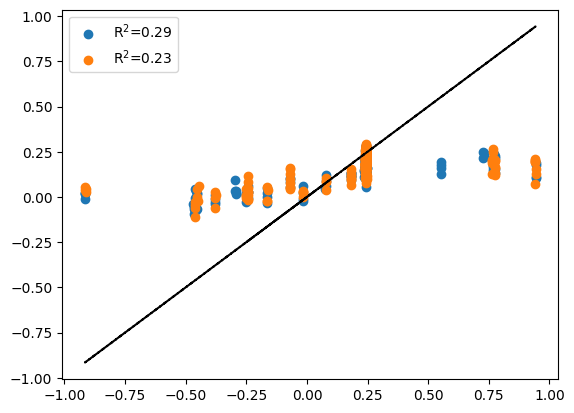

In [12]:
plt.scatter(y_train.flatten(),y_train_pred.flatten(),label="R$^{2}$="+f"{r2_score(y_train.flatten(),y_train_pred.flatten()):.2f}")
plt.plot(y_train.flatten(),y_train.flatten(),'k--')
plt.scatter(y_test.flatten(),y_test_pred.flatten(),label="R$^{2}$="+f"{r2_score(y_test.flatten(),y_test_pred.flatten()):.2f}")
plt.legend()
plt.show()

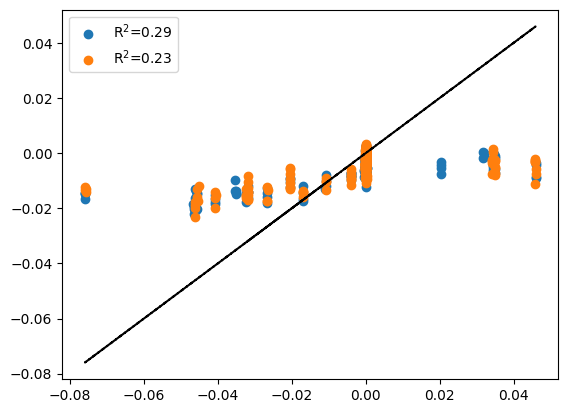

In [13]:
plt.scatter(unscaled_y_train.flatten(),unscaled_y_train_pred.flatten(),label="R$^{2}$="+f"{r2_score(unscaled_y_train.flatten(),unscaled_y_train_pred.flatten()):.2f}")

plt.plot(unscaled_y_train.flatten(),unscaled_y_train.flatten(),'k--')
plt.scatter(unscaled_y_test.flatten(),unscaled_y_test_pred.flatten(),label="R$^{2}$="+f"{r2_score(unscaled_y_test.flatten(),unscaled_y_test_pred.flatten()):.2f}")
plt.legend()
plt.show()

In [14]:
# Goal, error handling: RuntimeJobFailureError: 'Unable to retrieve job result. Job estimator_cv61fk0tqh9s73cvpdeg_f0fa_4 cancelled due to compilation timeout 8100000000000.'
